# Functional Connectivity Analysis
***

Now we have an idea of three important components to analyzing neuroimaging data:

1. Data manipulation
2. Cleaning and confound regression
3. Parcellation and signal extraction

In this notebook the goal is to integrate these 3 basic components and perform a full analysis of group data using **Intranetwork Functional Connectivity (FC)**. 

Intranetwork functional connectivity is essentially a result of performing correlational analysis on mean signals extracted from two ROIs. Using this method we can examine how well certain resting state networks, such as the **Default Mode Network (DMN)**, are synchronized across spatially distinct regions. 

ROI-based correlational analysis forms the basis of many more sophisticated kinds of functional imaging analysis.

## Notebook Outline
***

The outline of the notebook is divided into two parts. The first part directly uses what you've learned and builds upon it to perform the final functional connectivity analysis on group data. 

The second part shows how we can use Nilearn's convenient wrapper functionality to perform the same task with *significantly less effort*. 

#### Part A: Manual computation 
1. Functional data cleaning and confound regression
2. Applying a parcellation onto the data
3. Computing the correlation between two ROI time-series


#### Part B: Using Nilearn's high-level features
1. Using NiftiLabelsMasker to extract cleaned time-series
2. Computing the correlation between two ROI time-series


#### Part C: Visualization of Results

In [2]:
import os
from nilearn import signal as sgl
from nilearn import image as img
from nilearn import plotting as plot
from nilearn import datasets
import nibabel as nib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sub = '10788'

In [4]:
#Setting up directories
func_dir = '../data/ds000030/derivatives/fmriprep/sub-{}/func/'.format(sub)

#Pre-processed functional data in MNI space
func_file = 'sub-{}_task-rest_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'.format(sub)
func_path = os.path.join(func_dir,func_file) 

#Confounds.tsv extracted using FMRIPREP 
confound_file = 'sub-{}_task-rest_bold_confounds.tsv'.format(sub)
confound_path = os.path.join(func_dir,confound_file) 

#MNI Brainmask outputted from FMRIPREP
mask_file = 'sub-{}_task-rest_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz'.format(sub)
mask_path = os.path.join(func_dir,mask_file) 

### Part A: Manual Computation of Functional Connectivity
***

#### 1. Cleaning your functional data using filtering, dummy TR removal and confound regression
The first step to any functional analysis is to clean the data

We'll define a function to help extract our confound regressors from the .tsv file for us

In [6]:
#Refer to part_06 for code + explanation
def extract_confounds(confound_tsv,confounds,dt=True):
    '''
    Arguments:
        confound_tsv                    Full path to confounds.tsv
        confounds                       A list of confounder variables to extract
        dt                              Compute temporal derivatives [default = True]
        
    Outputs:
        confound_mat                    
    '''
    
    #Load in data using Pandas then extract relevant columns
    confound_df = pd.read_csv(confound_tsv,delimiter='\t') 
    confound_df = confound_df[confounds]
    
    #If using temporal derivatives 
    if dt:
        #For each column create a new column '<colname>_dt' containing the step-wise differences
        for col in confound_df.columns:
            confound_df['{}_dt'.format(col)] = confound_df[col].diff() 
    
    #Convert into a matrix of values (timepoints)x(variable)
    confound_mat = confound_df.values 
    
    #Return confound matrix
    return confound_mat
    

Let's clean our data!

In [8]:
#Load functional image
tr_drop = 4
func_img = img.load_img(func_path)
func_img = func_img.slicer[:,:,:,tr_drop+1:]

#Extract confounds
confounds = extract_confounds(confound_path,['X','Y','Z','RotX','RotY','RotZ','GlobalSignal',
                                            'aCompCor01','aCompCor02'])
confounds = confounds[tr_drop+1:,:] 

#Clean functional image
clean_img = img.clean_img(func_img,confounds=confounds,low_pass=0.08,high_pass=0.009,t_r=2,
                         mask_img=mask_path) 

#### 2. Setting up the parcellation scheme

To apply a parcellation we'll have to specify a parcellation to use. 
For this analysis we'll be using a spatially separated version [Yeo 2011 - 7 Networks](https://www.ncbi.nlm.nih.gov/pubmed/21653723).

We chose this parcellation since it nicely characterizes the **DMN**, our network of interest.  

In [ ]:
yeo_atlas = img.load_img('../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz') 

#Let's visualize it
plot.plot_roi(yeo_atlas,cmap='Paired')

Remember that in order to use the parcellation with our functional data it must have the same dimensions. It turns out that the parcellation schema has slightly different dimensions, so we need to resample: 

In [14]:
#We use "nearest" to preserve the label values (a label of 2.42 for example, doesn't and shouldn't exist) 
resamp_yeo7 = img.resample_to_img(yeo_7,clean_img,interpolation='nearest') 
print(resamp_yeo7.shape)
print(clean_img.shape)

(65, 77, 49)
(65, 77, 49, 147)


#### 3. Intra-network functional connectivity analysis
Intra-network functional connectivity analysis is determined by computing the correlation between the mean time-series of two spatially distinct regions within the same network. 

Thus we need to do:
1. Select 2 ROIs from the same network (DMN) 
2. Extract the mean time-series from both regions and compute the correlation between them

The first step is to select two ROIs from the DMN. We've already gone through the hassle of selecting these two regions but many possible combinations exist. 

In [21]:
#Select two ROIs and visualize
source_ROI = 44
target_ROI = 46

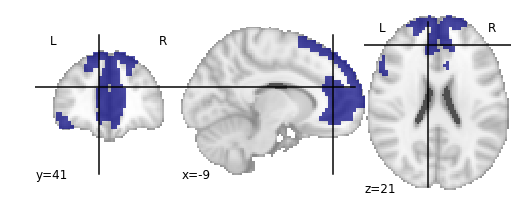

In [22]:
#Visualize the ROI, we can do this by masking our all values not matching our ROI
source_mask = img.math_img('a == {}'.format(source_ROI), a=resamp_yeo7) 

#Apply the mask to the data
masked_source = img.math_img('a*b',a=resamp_yeo7,b=source_mask) 

#Visualize
plot.plot_roi(masked_source) 

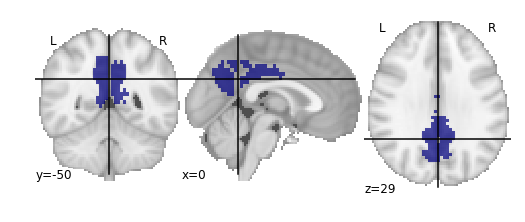

In [23]:
target_mask = img.math_img('a == {}'.format(target_ROI),a=resamp_yeo7)
masked_target = img.math_img('a*b',a=resamp_yeo7,b=target_mask)
plot.plot_roi(masked_target)

With our two regions selected, we'll now extract the mean time-series for each of our two ROIs

In [24]:
#Recall that in the parcellation, each voxel is labelled with a number corresponding to a distinct parcel
#We want to extract parcels belonging to our ROI.

#Pull the voxels indices belonging to the ROI 
yeo7_data = resamp_yeo7.get_data() 

#Get voxel coordinates (x,y,z) list of source and target ROIs
source_roi = np.where(yeo7_data == source_ROI)
target_roi = np.where(yeo7_data == target_ROI)

#Load up functional data to extract ROI voxels from
func_data = clean_img.get_data()

#Extract the list of voxel time-series belonging to each ROI
#This is now a (roi voxel)x(timepoints) array
source_ts = func_data[source_roi]
target_ts = func_data[target_roi] 

#We want to compute the mean timeseries of each list of voxels (source and target) 
#This will be a (1) x (timepoints) vector
mean_source_ts = np.mean(source_ts,axis=0)
mean_target_ts = np.mean(target_ts,axis=0) 

Now we've extracted two average time-series, one from the source, and one from the target.
The last step is to compute the correlation between them. This will tell us how well the average time-series from the two DMN regions synchronize with each other.

To do this we use <code>np.corrcoef(x,y)</code> which returns a matrix of form:

$$ \rho=
\left( \begin{matrix}
\sigma_{1,1} & \sigma_{1,2} \\
\sigma_{2,1} & \sigma_{2,2}
\end{matrix} \right)
$$

The diagonals represent the correlation of signals with themselves. These are always $1$. The off-diagonal represents the correlation of one signal with another and represents what we want. In addition the matrix is symmetric so: $\sigma_{1,2} = \sigma_{2,1}$. 

In [29]:
#Compute correlation and pull the value in the first row, second column
source_targ_corr = np.corrcoef(mean_source_ts,mean_target_ts)[0,1]
print(source_targ_corr)

0.7425743212929571


### Part B: Using nilearn's label masker to extract the timeseries
***
nilearn has a built in function for extracting timeseries from functional files and doing all the extra signal processing at the same time!

In [ ]:
from nilearn import input_data

masker = input_data.NiftiLabelsMasker(labels_img=yeo_atlas,
                                      standardize=True,
                                      memory='nilearn_cache',
                                      verbose=1)

### Using nilearn's ConnectivityMeasure to calculate our correlation matrix

The avalable options are “correlation”, “partial correlation”, “tangent”, “covariance”, “precision” or other utilites in sci-py could be plugged in ([see here for an example](http://nilearn.github.io/auto_examples/03_connectivity/plot_multi_subject_connectome.html#sphx-glr-auto-examples-03-connectivity-plot-multi-subject-connectome-py)).

Let's do correlation this time.

In [ ]:
from nilearn.connectome import ConnectivityMeasure

connectivity_metric = 'correlation'
connectivity_measure = ConnectivityMeasure(kind=connectivity_metric)

In [ ]:
import bids

In [ ]:
layout = bids.layout.BIDSLayout('../data/ds000030')

In [ ]:
subjects = layout.get_subjects()

In [ ]:
pooled_subjects = []
ctrl_subjects = []
schz_subjects = []

for sub in subjects:
    func_file = layout.get(subject='10171', modality='func', type='preproc', extensions='nii.gz', return_type='file')[0]
    confound_file = layout.get(subject='10171', modality='func', type='confounds', return_type='file')[0]
    func_img = img.load_img(func_file)
    func_img = func_img.slicer[:,:,:,5:]
    confounds = extract_confounds(confound_file,['X','Y','Z','RotX','RotY','RotZ','GlobalSignal'])
    confounds = confounds[5:,:] 
    time_series = masker.fit_transform(func_img, confounds)
    pooled_subjects.append(time_series)
    if sub.startswith('1'):
        ctrl_subjects.append(time_series)
    if sub.startswith('5'):
        schz_subjects.append(time_series)

In [ ]:
correlation_measure = ConnectivityMeasure(kind='correlation')

In [ ]:
ctrl_correlation_matrices = correlation_measure.fit_transform(ctrl_subjects)
schz_correlation_matrices = correlation_measure.fit_transform(schz_subjects)

In [ ]:
mean_correlation_matrix = correlation_measure.mean_

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from nilearn import plotting

def plot_matrices(matrices, matrix_kind):
    n_matrices = len(matrices)
    fig = plt.figure(figsize=(n_matrices * 4, 4))
    for n_subject, matrix in enumerate(matrices):
        plt.subplot(1, n_matrices, n_subject + 1)
        matrix = matrix.copy()  # avoid side effects
        # Set diagonal to zero, for better visualization
        np.fill_diagonal(matrix, 0)
        vmax = np.max(np.abs(matrix))
        title = '{0}, subject {1}'.format(matrix_kind, n_subject)
        plotting.plot_matrix(matrix, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
                             title=title, figure=fig, colorbar=False)


In [ ]:
plot_matrices(ctrl_correlation_matrices, 'correlation')

In [ ]:
plot_matrices(schz_correlation_matrices, 'correlation')

In [ ]:
ctrl_mean_correlation_matrix = ctrl_correlation_matrices.mean(axis=0)
schz_mean_correlation_matrix = schz_correlation_matrices.mean(axis=0)

In [ ]:
ctrl_mean_correlation_matrix[43, 45]

In [ ]:
schz_mean_correlation_matrix[43,45]